In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for the Statistical Tests
from scipy.stats import skew,shapiro
from scipy.stats import ttest_ind, f_oneway,kruskal,levene
from scikit_posthocs import posthoc_dunn
from statsmodels.api  import qqplot
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Filtering the warnings
from warnings import filterwarnings
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

# Visualization Settings
#mpl_style(dark = True)
palette1 = ['#90A6B1', '#037d97','#E4591E']
palette2 = ['#A07CD5', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']
palette3 = ['#90A6B1', '#037d97', '#C09741']


In [3]:
df = pd.read_csv("WA_Marketing-Campaign.csv").rename(columns={"week":"Week"})
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,Week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [4]:
unique_values = df.nunique().to_frame().T
unique_values.index = ["Number of Unique Values"]
unique_values

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,Week,SalesInThousands
Number of Unique Values,10,3,137,25,3,4,517


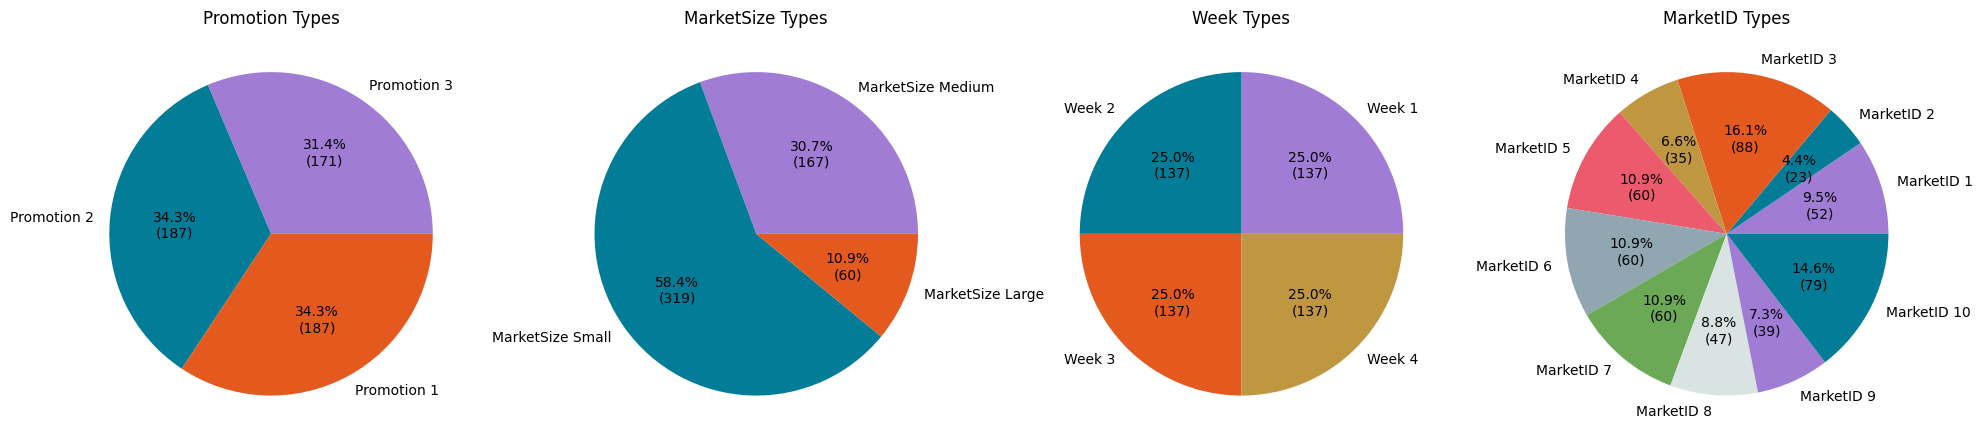

In [5]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
def plot_pie(*args_list):
    args_list = args_list[0]
    fig,axes= plt.subplots(1,len(args_list), figsize = (len(args_list)*6,len(args_list)*4))
    for i,col in enumerate(args_list):
        counts = df.groupby(col)["MarketSize"].count()
        label = [f"{col} {x}" for x in df[col].unique()]
        axes[i].pie(x=counts,labels=label,colors = palette2, autopct=lambda pct: func(pct, counts.values))
        axes[i].set_title(f"{col} Types")
    plt.show()
    
plot_pie(["Promotion","MarketSize","Week","MarketID"])

In [6]:
cross_values = pd.crosstab(index = df["MarketSize"],columns=df["Promotion"],values=df["SalesInThousands"],aggfunc="mean",margins=True).style.format("{:.2f}")
cross_values.highlight_max(color = "green",axis = 1)

Promotion,1,2,3,All
MarketSize,,,,
Large,75.24,60.32,77.20,70.12
Medium,47.67,39.11,45.47,43.99
Small,60.16,50.81,59.51,57.41
All,58.10,47.33,55.36,53.47


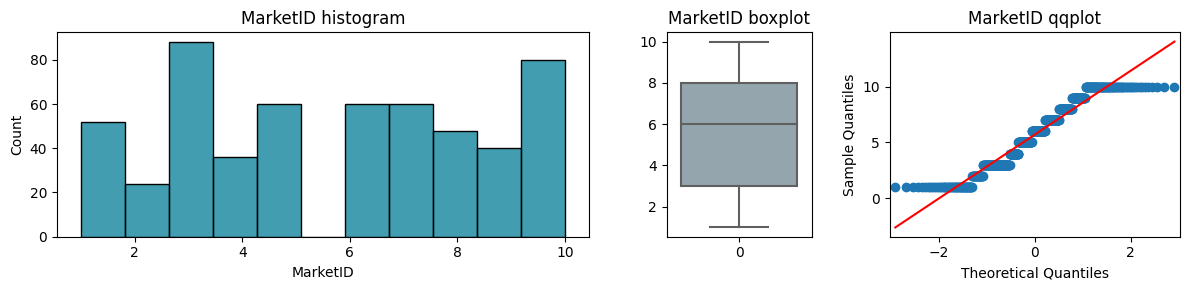

The skewness value for the MarketID is -0.0182
The normality index for MarketID is: 5.9e-15


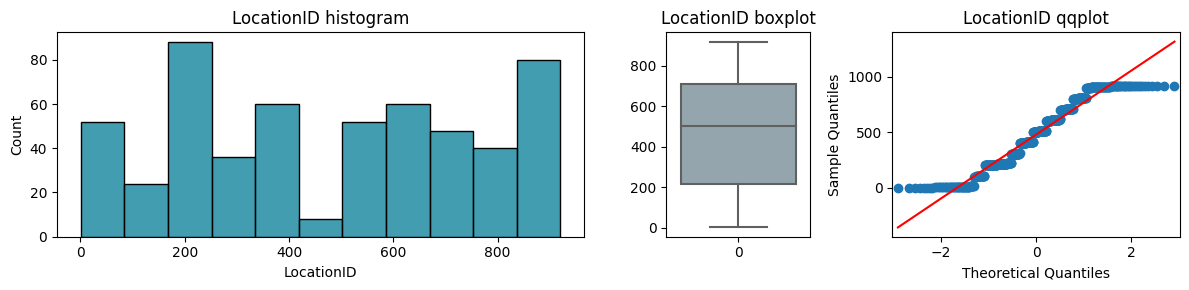

The skewness value for the LocationID is -0.0160
The normality index for LocationID is: 3.53e-14


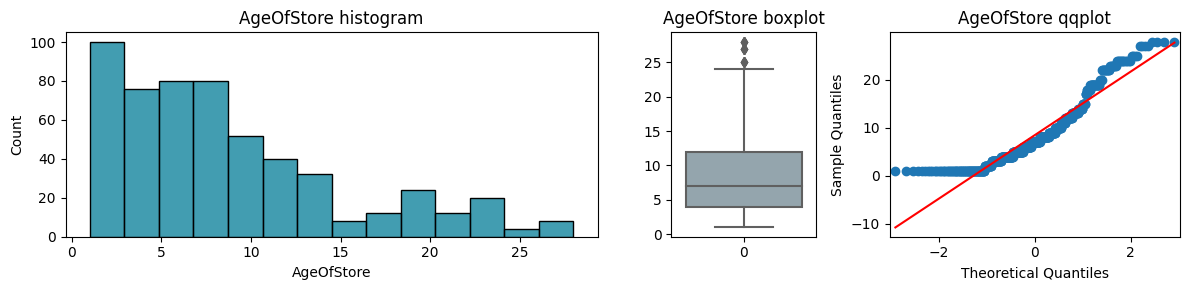

The skewness value for the AgeOfStore is 1.0387
The normality index for AgeOfStore is: 3.19e-19


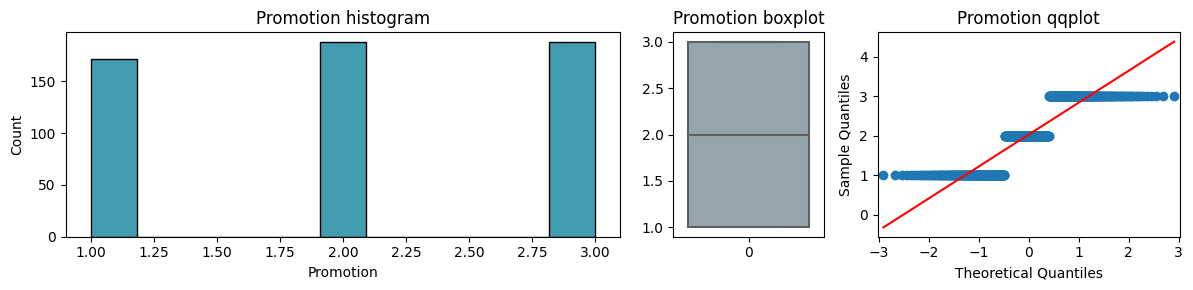

The skewness value for the Promotion is -0.0532
The normality index for Promotion is: 1.05e-25


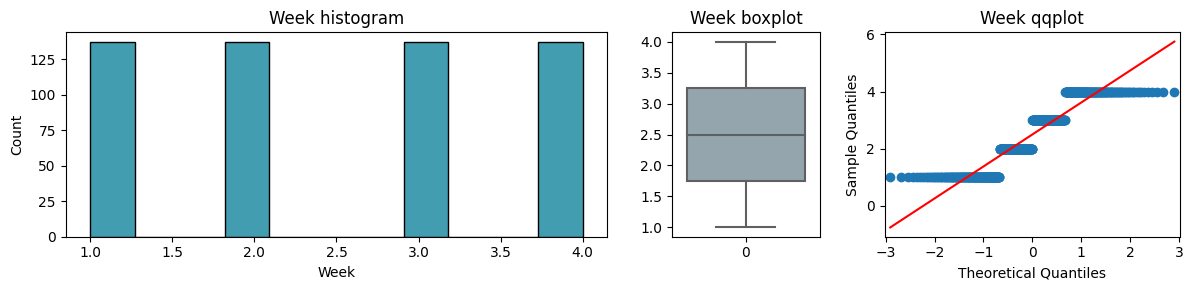

The skewness value for the Week is 0.0000
The normality index for Week is: 5.56e-22


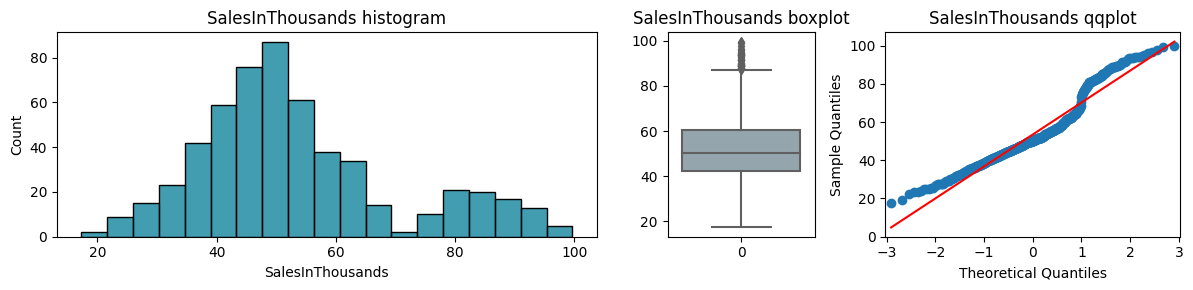

The skewness value for the SalesInThousands is 0.8043
The normality index for SalesInThousands is: 9.39e-15


In [7]:
def slices(df,colname):
    slice  = [df[df[colname] == i]["SalesInThousands"].tolist() for i in df[colname].unique()]
    return slice

def generate_numerical_viz(data):
    numericals = data.nunique()[data.nunique() > 50].index.tolist()    
    numericals = data.select_dtypes(include=["float","integer"]).columns.tolist()
    for i in data[numericals]:
        fig, axes = plt.subplots(1,3,figsize = (12,3),gridspec_kw={'width_ratios': [2.2,0.6,1.2]})
        sns.histplot(data[i],ax=axes[0],color = palette3[1])
        axes[0].set_title(f"{i} histogram")
        sns.boxplot(data[i],ax=axes[1],palette = palette3)
        axes[1].set_title(f"{i} boxplot")
        qqplot(data[i],ax = axes[2],line="s")
        axes[2].set_title(f"{i} qqplot")
        plt.tight_layout()
        plt.show()
        print(f"The skewness value for the {i} is {skew(data[i]):.4f}")
        print("The normality index for {} is: {:.3g}".format(i,shapiro(df[i])[1]))

generate_numerical_viz(df)

The important value here is the `SalesInThousands` for us. It looks 

In [8]:
def plot_dist(df,colname):
    data_list = slices(df,colname)
    if len(data_list) % 3 == 0:
        row_no = len(data_list) // 3
    else:
        row_no = (len(data_list) // 3 +1)
    fig,axes = plt.subplots(row_no,3, figsize= (6*len(data_list),4))
    plt.suptitle(f"Sales Distributions per {colname}")
    for k in range(len(data_list)):
        class_name = df[colname].unique()
        sns.distplot(data_list[k], ax = axes[k],label = f"{colname} {class_name[k]}",color = palette2[k])
        axes[k].legend()
        axes[k].grid(False)
    plt.tight_layout()
    plt.show()

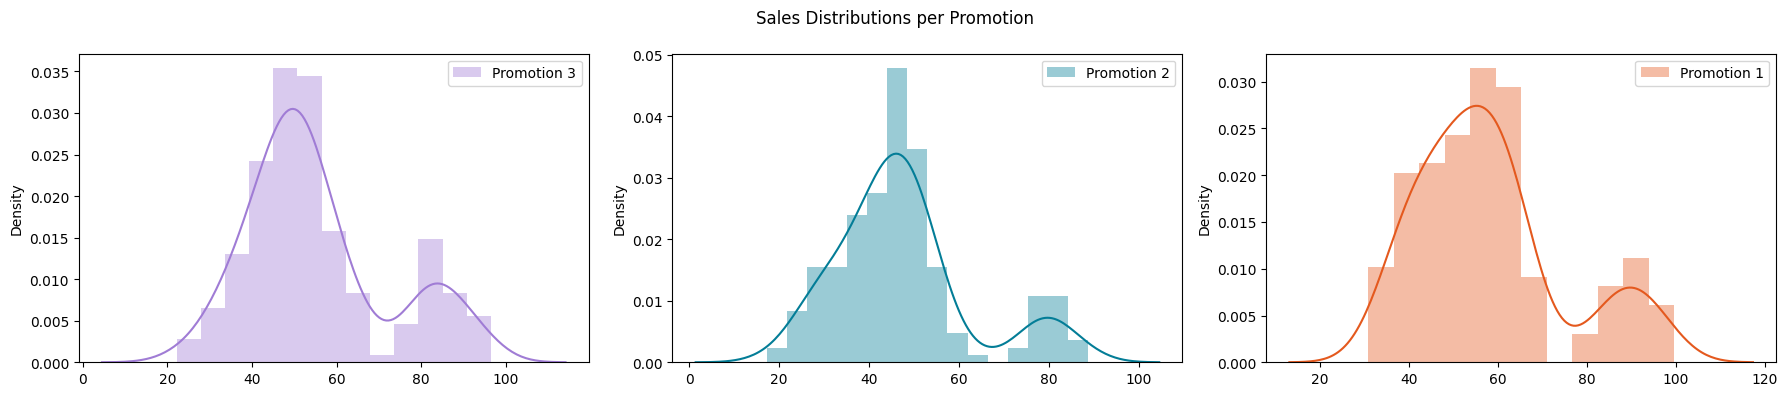

In [9]:
plot_dist(df,"Promotion")

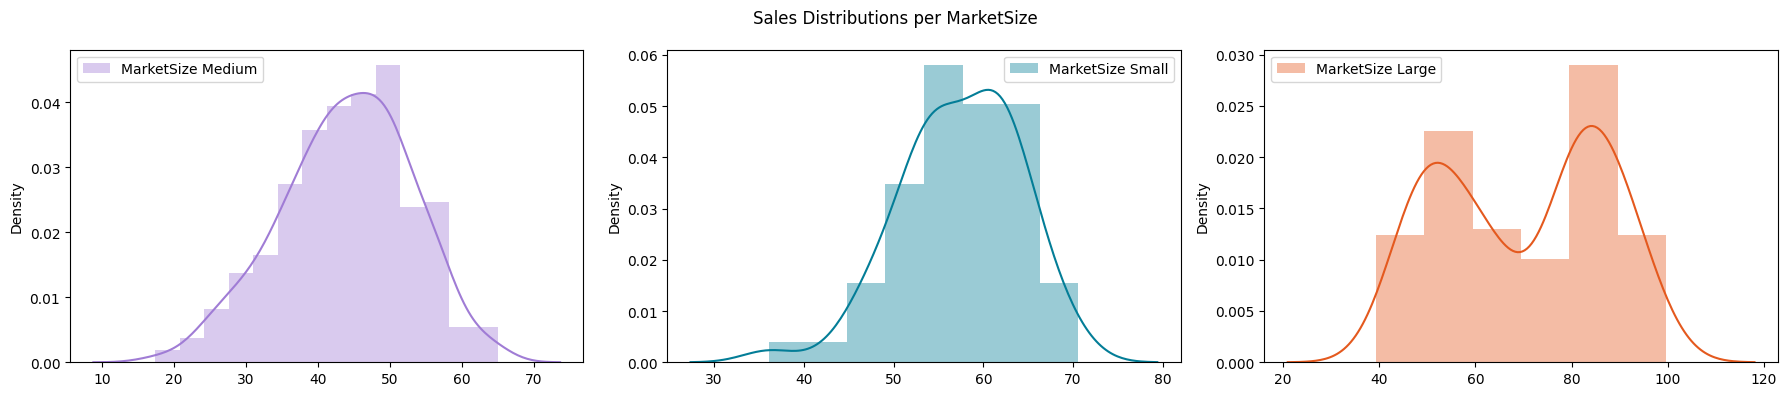

In [10]:
plot_dist(df,"MarketSize")

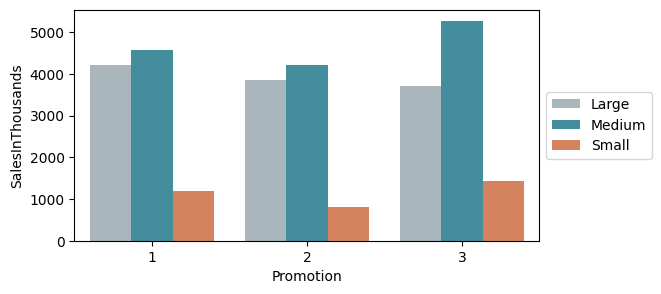

In [11]:
grouped = df.groupby(["Promotion","MarketSize"])["SalesInThousands"].sum().reset_index()
plt.figure(figsize=(6,3))
sns.barplot(data = grouped, x = "Promotion", y = "SalesInThousands",hue = "MarketSize",palette=palette1,alpha = 0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Parametric Tests
We need to know that our data needs to meet the parametric assumptions: normality and equal variance. After the EDA process, we know that the `SalesInThousands` column is not normally distributed. In this case, I need to use the Kruskal-Wallis test as a substitute for the ANOVA test. 

After comparing all three variables, I continued my analysis with the Dunn test to check the pairwise relationships between categories. 

In [12]:
print("p value for the Normality test:",shapiro(df["SalesInThousands"])[1])

p value for the Normality test: 9.385896702592596e-15


## Kruskal-Wallis and Dunn tests
Let's create a couple of functions that run Kruskal and Dunn tests for the desired columns in the data.
There are various categorical columns in the data, these functions will allow us to check for significance of impact not only by the promotion types but by all categories.

Therefore, we can check the significance in smaller granularity. For example, we can check whether market size makes a difference in sales or not. 
But before everything, let's check the effect of promotions.

In [13]:
def conduct_kruskal(args_list):
    # Check if there are at least 3 arguments
    if len(args_list) < 3:
        print("Error: At least 3 arguments are required.")
    # Perform one-way ANOVA test
    try:
        result = kruskal(*args_list)
        return result 
    except:
        return "Not Enough Classes to Compare!"
    

def conduct_levene(args_list):
    # Check if there are at least 3 arguments
    if len(args_list) < 3:
        print("Error: At least 3 arguments are required.")
    # Perform one-way ANOVA test
    try:
        result = levene(*args_list)
        return result 
    except:
        return "Not Enough Classes to Compare!"
   
def test_for_significance_kruskal(df, colname):
    data_list = slices(df,colname)
    result = conduct_kruskal(data_list)
    if type(result) != str:            
        if result[1] < 0.05:
            dunn = posthoc_dunn(data_list)
            dunn = dunn < 0.05 / 3
            #print(dunn)
            display(dunn.style.highlight_max(color = "darkgreen"))        
            print(f"There is a significant difference between promotions.\n p value:")
            return "{:.3g}".format(result[1])
        else:
            print(f"No difference \n p value:")
            return "{:.3g}".format(result[1])
    else:
        return result
    

def test_for_significance_levene(df, colname):
    data_list = slices(df,colname)
    result = conduct_levene(data_list)
    return result

In [14]:
test_for_significance_kruskal(df,"Promotion")

,1,2,3
1,False,True,False
2,True,False,True
3,False,True,False


There is a significant difference between promotions.
 p value:


'2.67e-12'

Kruskal's test shows that there is a clear change in sales when the company varies its promotion methods. 
The Dunn test states that Promotion2 is statistically different from others with respect to the impact it makes on sales. However, the other two promotions do not show statistical differences meaning that the mean difference might result from the sample choice. 
Let's check the sales means for each of these promotions.

In [15]:
promotion_sales = df.groupby("Promotion")["SalesInThousands"].mean().to_frame().T.style.highlight_min(axis=1,color = "#FF475A")
percent = ((47.32 - np.mean([58.09 , 55.36])) / np.mean([58.09 , 55.36])) * 100
print("The change in the sales if the company uses Promotion2 instead of others: \n {:.1f}%".format(percent))
promotion_sales

The change in the sales if the company uses Promotion2 instead of others: 
 -16.6%


Promotion,1,2,3
SalesInThousands,58.099012,47.329415,55.364468


Promotion 2 generates much less revenue compared to the other two. It is logical for the company to abandon it. 

Now, I want to check if running different promotions on different data slices gives us more insight. For example, let's see if running on different promotions on Large market size can statistically affect the sales.

In [16]:
my_data = df[df.MarketSize=="Large"]
test_for_significance_kruskal(my_data,"Promotion")

,1,2,3
1,False,False,True
2,False,False,True
3,True,True,False


There is a significant difference between promotions.
 p value:


'1.23e-09'

According to the Dunn test, running promotion1 or promotion2 does not make sense only if the market size is large. This means the company can choose the promotion with the lowest costs in markets with large sizes. Knowing this piece of information increases the flexibility in operations and gives the company more options in its strategy development. Let's assume that the cost of running promotion2 is much less than that of promotion1, in this case, it would be logical to run promotion2 since the sales are not different in large markets.

I go one step further and create a function that crawls through the entire dataset and finds the subclasses of data that promotion type does not matter in sales. 
For example, I want to know the age of stores that are not affected by promotion type. 

The function above slices the data for each subclass and conducts a Kruskal-Wilk test. If the test result is insignificant, the name of the column and its subclass are added to a dictionary. Such methods may allow the organization to make little adjustments in their promotion strategies.

In [17]:

def conduct_kruskal_silent(args_list):
    try:
        result = kruskal(*args_list)
        return result 
    except:
        return "Not Enough Classes to Compare!"
    

def test_for_significance_silent(df, colname):
    data_list = slices(df,colname)
    result = conduct_kruskal_silent(data_list)
    if type(result) != str:           
        return result[1]
    else:
        return result

def check_all(data,test_col):
    all_classes = {}
    columns_to_check = [x for x in data.columns if x not in [test_col,"SalesInThousands"]]
    for col in columns_to_check:
        subclasses = {}
        for my_class in data[col].unique():
            result = test_for_significance_silent(data[data[col] == my_class],"Promotion")
            if type(result) != str:
                if result > 0.05:
                    subclasses[my_class] = result
            else:
                subclasses[my_class] = "Not Enough Subclasses to compare"
        all_classes[col] = subclasses
    return all_classes
scanned_data = check_all(df,"Promotion")

After going through the data, the function found that some subclasses in `LocationID`, `AgeOfStore` and `MarketID` are not affected by promotion types. 

In [18]:
indifferent_classes = {k:len(v) for k,v in scanned_data.items()}
indifferent_classes = pd.Series(index = indifferent_classes.keys(),data = indifferent_classes.values()).reset_index()
indifferent_classes.columns = ["Column_name","#OfIndifferentClasses"]
indifferent_classes.sort_values("#OfIndifferentClasses",ascending=False,inplace=True)
indifferent_classes

,Column_name,#OfIndifferentClasses
2,LocationID,137
3,AgeOfStore,15
0,MarketID,2
1,MarketSize,0
4,Week,0


In [19]:
scanned_data["AgeOfStore"]

{4: 0.41778481317031524,
 10: 0.8542396057680982,
 15: 0.5637028616507738,
 6: 0.3277626811789031,
 22: 0.08942935902899304,
 11: 0.4668542708227247,
 13: 0.39606582070894025,
 7: 0.1541283607788894,
 9: 0.1517113067070956,
 28: 'Not Enough Subclasses to compare',
 25: 'Not Enough Subclasses to compare',
 18: 'Not Enough Subclasses to compare',
 27: 'Not Enough Subclasses to compare',
 17: 'Not Enough Subclasses to compare',
 20: 'Not Enough Subclasses to compare'}

When details are checked, we find that some subclasses do not react to changes in promotion. Although there are many of them, the most indifferent subclass to promotion change is `10`. Stores with 10 years of age follow a similar sales pattern regardless of promotion type. 

**Note:** You may think the subclass scanning do not make much difference. However, I want to stress the significance of attention to detail and granular analysis, even for relatively small datasets. Organizations dealing with big data can gain considerable advantages by optimizing operations and extracting knowledge from smaller partitions. For instance, analyzing data for different markets (e.g., European and Asian) can reveal unique opportunities due to cultural, socioeconomical, and political variations. Such adjustments in operations lead to increased returns and improved decision-making.

## Business Insights and Recommendations 

**Stop or Modify Promotion2:**  First of all, we know that Promotion2 is underperforming, it is best to cease the operations continuing under this promotion in stores. It is also acceptable to modify the offers, and deals in the promotion2 and try a new promotion instead. 

**Allocate Resources to Successful Promotions:**  The company should use the resources for promotions with high returns to achieve efficiency and growth. Promotion1 and Promotion3 yield more revenue, therefore allocating time and money to run these two promotions should be the priority for the company. 

**Investigate the reasons behind underperformance:** It is always good to dig deep and understand the underlying factors that cause underperformance so that we can learn about the business on a more detailed scale. The company may find a root cause that is already in use in other operations, so they can remove this hunch from all processes. Such an in-depth analysis may end up granting the company a chance to purify/optimize its decision-making processes.

**Derive Alternative Promotions:** By analyzing the methods followed in these three promotions, the company can learn from both mistakes and successes. Amplifying high-performer methods and removing/modifying underperformers allow the decision-makers to create better alternative strategies that may work even better than previous ones. In this process, it is important to include the perspectives coming from various departments so that a wider range of possibilities can be taken into account.

**Take Advantage of Niches:** The analysis has uncovered valuable insights into the behavior of different subclasses within the data. Leveraging this information can provide a competitive edge to the organization by capitalizing on unique opportunities in specific market segments or customer groups. The company may benefit from competitive advantage, segmented marketing, and advanced resource allocation by analyzing niches.

**Communication and Reporting:** The analysis findings should be shared throughout the company to foster a data-driven approach. This ensures others benefit from the insights, improves overall organizational performance, and reduces resource wastage on unsuccessful endeavors.